###### Import libraries

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

###### Functions

In [160]:
def splitting_fastestlaptime(fastestlaptime):
    '''
    function to split fastest time lap into 2 parts - minutes and seconds
    '''
    if ":" not in fastestlaptime:
        output = 0
    else:
        split_input = fastestlaptime.split(":")
        output = int(split_input[0])*60 + float(split_input[1])
    return output

In [161]:
def preprocess_input_df(input_df):
    '''
    function to split the fastestlaptime in the df, merge with status id and only keep required status id
    '''
    input_df['fastestLapTime_calculated'] = input_df['fastestLapTime'].apply(lambda x: splitting_fastestlaptime(x))
    results_combined = pd.merge(input_df, status, on=["statusId"])
    results_combined=results_combined[results_combined.status.isin(status_to_keep)].reset_index(drop=True)
    return results_combined

#### Read in datasets

In [162]:
sprint_results = pd.read_csv("sprint_results.csv")
gp_results = pd.read_csv("results.csv")
status = pd.read_csv("status.csv")
drivers = pd.read_csv("drivers.csv")

In [163]:
sprint_results.head(1)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1


In [164]:
gp_results.head(1)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1


In [165]:
status.head(1)

,statusId,status
0,1,Finished


In [166]:
drivers.head(1)

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton


In [167]:
sprint_results.dtypes

resultId           int64
raceId             int64
driverId           int64
constructorId      int64
number             int64
grid               int64
position          object
positionText      object
positionOrder      int64
points             int64
laps               int64
time              object
milliseconds      object
fastestLap        object
fastestLapTime    object
statusId           int64
dtype: object

In [168]:
## get unique race ids for sprint race
sprint_raceids=list(sprint_results['raceId'].unique())
## get grand prix results only for races that have sprint races
gp_results_filtered=gp_results[gp_results.raceId.isin(sprint_raceids)].reset_index(drop=True)
## only keeping data where race is completed (falls under these categories)
status_to_keep = ['Finished', '+1 Lap', '+2 Laps']
## getting preprocessed data
gp_results_filtered_combined = preprocess_input_df(gp_results_filtered)
sprint_results_combined = preprocess_input_df(sprint_results)
## merge both gp and sprint dataframes to get a combined result
overall = gp_results_filtered_combined.merge(sprint_results_combined, on = ["raceId", "driverId"], how = 'inner')
## keep only required columns
overall = overall[['raceId', 'driverId', 'position_x', 'points_x', 'fastestLapTime_calculated_x', 
                  'position_y', 'points_y', 'fastestLapTime_calculated_y']]
## rename columns
overall = overall.rename(columns={"position_x": "position_race", "points_x": "points_race", 
                                  "fastestLapTime_calculated_x": "fastestlaptime_race", "position_y": "position_sprint", 
                                  "points_y": "points_sprint", "fastestLapTime_calculated_y": "fastestlaptime_sprint"})
## need to change position to int
overall['position_race'] = overall['position_race'].astype(int)
overall['position_sprint'] = overall['position_sprint'].astype(int)

In [171]:
## for these drivers, we want to see the average of the following metrics across their races
## 1. position, 2. points, 3. fastest lap time 
## for both sprint and race
## we have to groupby driver and get average of remaining columns 
plotting_table = overall.groupby('driverId').mean().reset_index()
plotting_table = plotting_table.merge(drivers, on = 'driverId')
plotting_table = plotting_table[['driverId', 'raceId', 'position_race', 'points_race', 'fastestlaptime_race', 
                                'position_sprint', 'points_sprint', 'fastestlaptime_sprint', 'code']]

## remove outliers based on number of races the driver has had
df_race_count = overall.groupby('driverId').count().reset_index()
one_race_drivers = list(df_race_count[df_race_count.raceId ==1].driverId)
plotting_table = plotting_table[~plotting_table.driverId.isin(one_race_drivers)].reset_index(drop=True)

In [173]:
plotting_table.head(1)

,driverId,raceId,position_race,points_race,fastestlaptime_race,position_sprint,points_sprint,fastestlaptime_sprint,code
0,1,1088.25,4.75,13.5,83.497,7.0,1.625,85.38575,HAM


###### plotting graphs

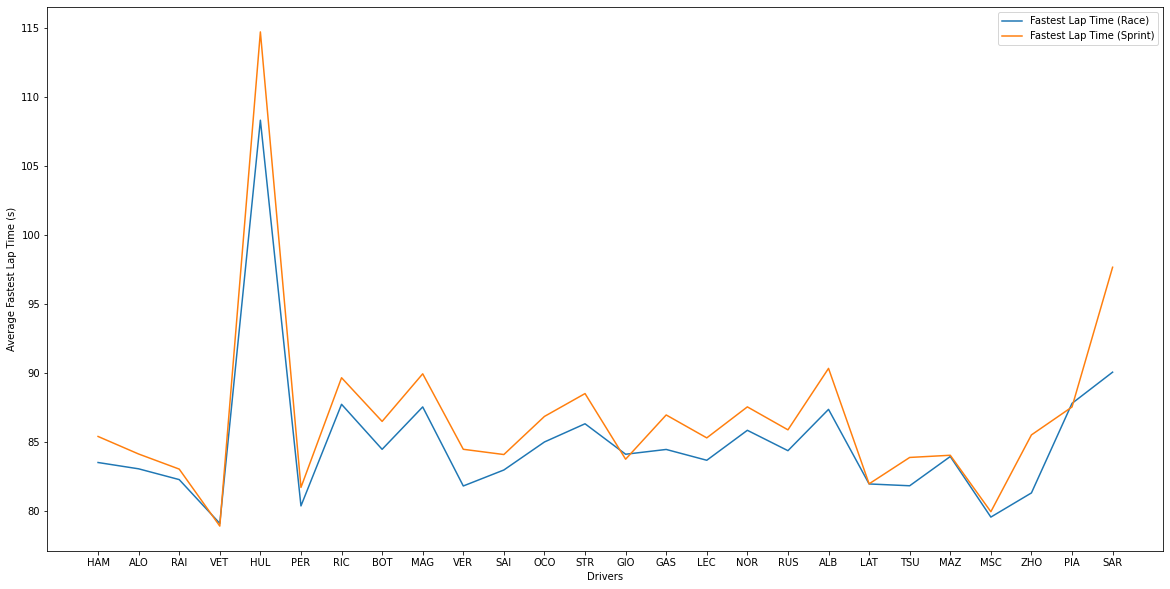

In [115]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.plot(plotting_table['code'], plotting_table['fastestlaptime_race'], label = 'Fastest Lap Time (Race)') 
plt.plot(plotting_table['code'], plotting_table['fastestlaptime_sprint'], label = 'Fastest Lap Time (Sprint)') 
plt.xlabel("Drivers") 
plt.ylabel("Average Fastest Lap Time (s)") 
plt.legend() 
plt.show()

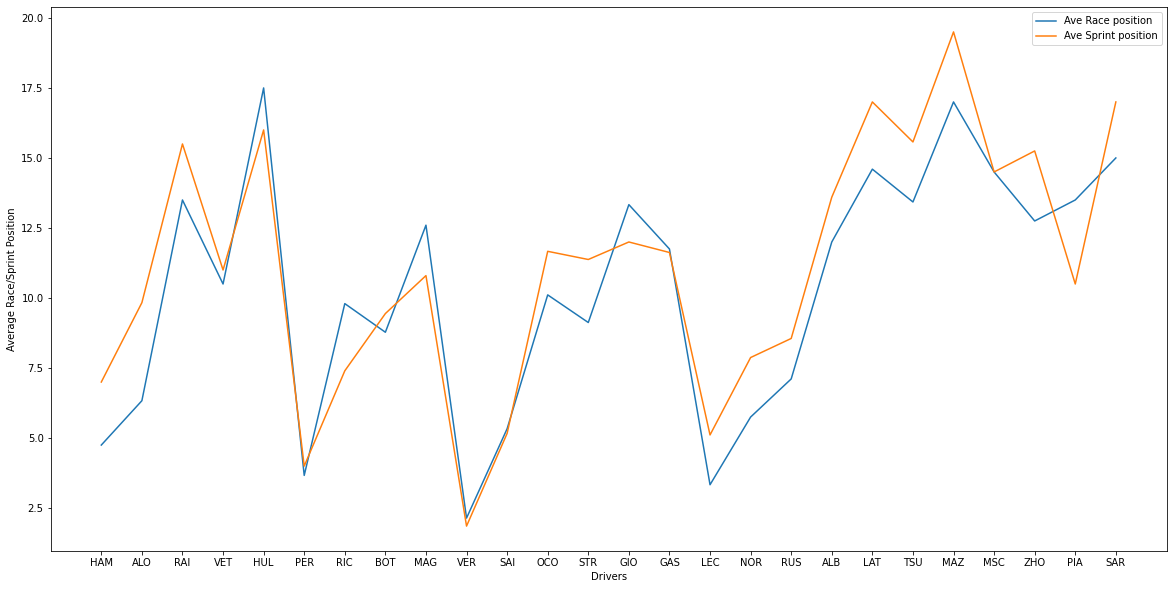

In [116]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.plot(plotting_table['code'], plotting_table['position_race'], label = 'Ave Race position') 
plt.plot(plotting_table['code'], plotting_table['position_sprint'], label = 'Ave Sprint position') 
plt.xlabel("Drivers") 
plt.ylabel("Average Race/Sprint Position") 
plt.legend() 
plt.show() 